[empirix.ru](https://empirix.ru/)

# Trend vs. Flat

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

## Ticker from finance.yahoo.com

In [6]:
ticker = "GBPUSD=X"
date_from = '2003-01-01' # 2003
date_to = '2022-09-23'

df = yf.download(ticker, start=date_from, end=date_to)

# Update DF by removing redundant columns
df = df['Close'].to_frame()
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2003-12-01,1.718597
2003-12-02,1.730313
2003-12-03,1.728101
2003-12-04,1.720697
2003-12-05,1.733102
...,...
2022-09-16,1.145265
2022-09-19,1.143314
2022-09-20,1.144322


In [7]:
# Simple moving average - 3
sma_1 = 20

mult = 1.75

sma_2 = int(sma_1 * mult)
sma_3 = int(sma_2 * mult)

print(sma_1, sma_2, sma_3)

20 35 61


## Dataframe, 3 SMAs

In [8]:
# Calculate SMA using .rolling(window).mean()
df[f'SMA{sma_1}'] = df['Close'].rolling(sma_1).mean()
df[f'SMA{sma_2}'] = df['Close'].rolling(sma_2).mean()
df[f'SMA{sma_3}'] = df['Close'].rolling(sma_3).mean()

# Remove null values
df.dropna(inplace=True)

# show df
df.head()

,Close,SMA20,SMA35,SMA61
Date,,,,
2004-02-23,1.868390,1.858699,1.844764,1.808076
2004-02-24,1.890002,1.861865,1.846727,1.810886
2004-02-25,1.872309,1.864725,1.848285,1.813214
2004-02-26,1.863308,1.867035,1.849126,1.815430
2004-02-27,1.869508,1.869247,1.849738,1.817870


## Plot chart

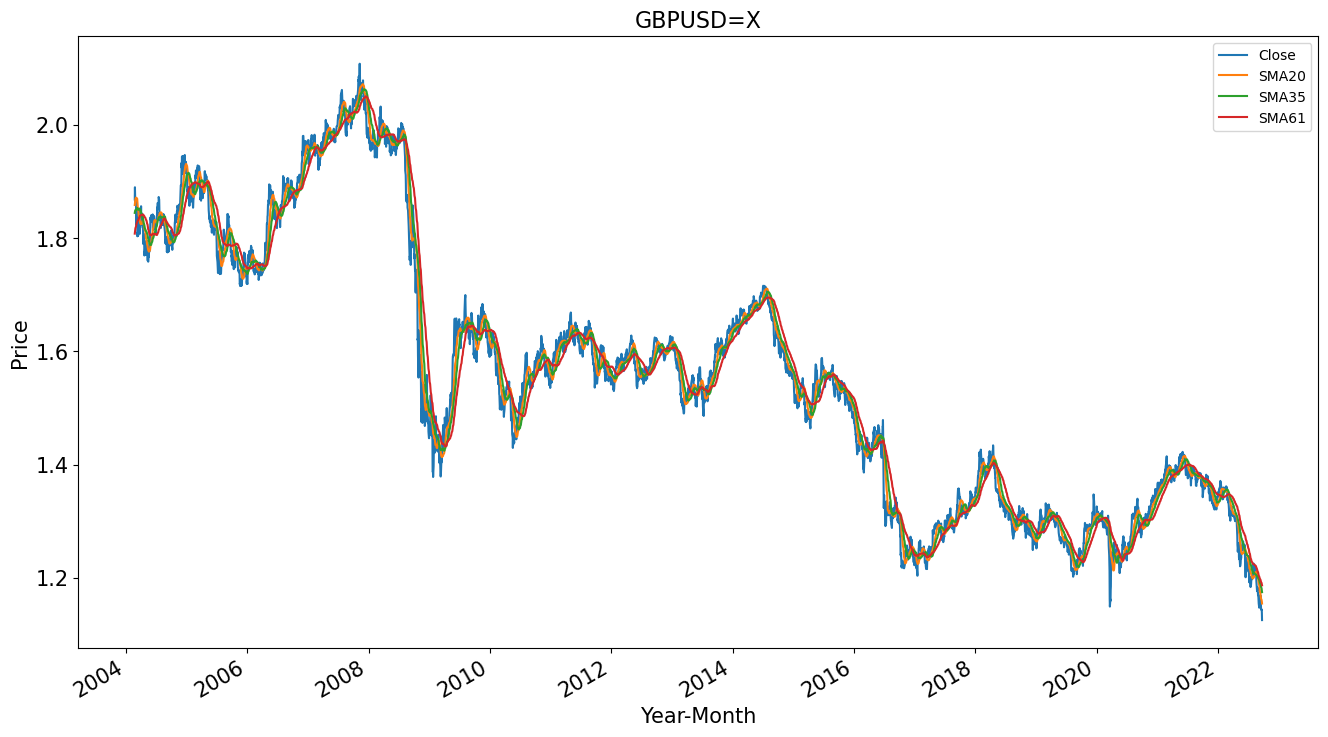

In [9]:
# plt.figure(figsize=(16, 16))
df[['Close',
    f'SMA{sma_1}', 
    f'SMA{sma_2}', 
    f'SMA{sma_3}']].plot(label=ticker, figsize=(16, 9))

# Set the title and axis label
plt.title(ticker, fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# # Show the plot
plt.show()

In [10]:
# Calculate states: trend of flat

df['uptrend'] = (
    ((df[f'SMA{sma_1}'] > df[f'SMA{sma_2}']) 
     & (df[f'SMA{sma_2}'] > df[f'SMA{sma_3}']))).astype(int)

df['downtrend'] = (
    ((df[f'SMA{sma_1}'] < df[f'SMA{sma_2}'])          
     & (df[f'SMA{sma_2}'] < df[f'SMA{sma_3}']))).astype(int)

df['flat'] = ((df['uptrend'] == 0) & (df['downtrend'] == 0)).astype(int)
df[470:477]

,Close,SMA20,SMA35,SMA61,uptrend,downtrend,flat
Date,,,,,,,
2005-12-14,1.771385,1.735974,1.743210,1.753217,0,1,0
2005-12-15,1.765287,1.738244,1.742678,1.752685,0,1,0
2005-12-16,1.772987,1.741108,1.742657,1.752377,0,1,0
2005-12-19,1.762611,1.743434,1.742481,1.752163,0,0,1
2005-12-20,1.756605,1.745189,1.742247,1.751797,0,0,1
2005-12-21,1.744714,1.746320,1.741350,1.751431,0,0,1
2005-12-22,1.737710,1.747081,1.740388,1.750914,0,0,1


In [11]:
# % in each state
uptr = df['uptrend'].sum() / len(df)
dntr = df['downtrend'].sum() / len(df)
flat = df['flat'].sum() / len(df)

print(f"Uptrend: {uptr}\nDowntrend: {dntr}\nFlat: {flat}")

Uptrend: 0.32471026490066224
Downtrend: 0.3536837748344371
Flat: 0.3216059602649007


## Trend vs. Flat pie chart

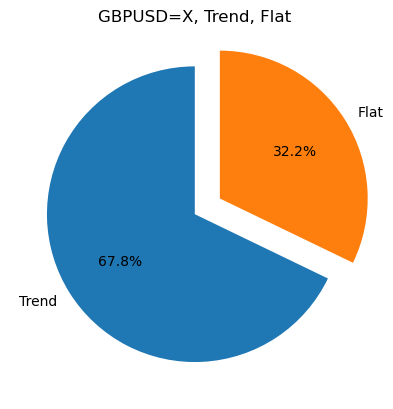

In [12]:
# Pie chart
values = [uptr + dntr, flat]
labels = ["Trend", "Flat"]
myexplode = [0, 0.2]
plt.pie(values, labels=labels, startangle=90, explode=myexplode, 
        autopct="%1.1f%%")
plt.title(f"{ticker}, Trend, Flat")
plt.show()

<hr>

# Scan Tickers

In [15]:
def trend_flat(ticker, date_from, date_to, sma_1, sma_mult):
    df = yf.download(ticker, start=date_from, end=date_to, progress=True)

    # Update DF by removing redundant columns
    df = df['Close'].to_frame()

    # Calculate SMA using .rolling(window).mean()
    sma_2 = int(sma_1 * sma_mult)
    sma_3 = int(sma_2 * sma_mult)

    df[f'SMA{sma_1}'] = df['Close'].rolling(sma_1).mean()
    df[f'SMA{sma_2}'] = df['Close'].rolling(sma_2).mean()
    df[f'SMA{sma_3}'] = df['Close'].rolling(sma_3).mean()

    # Remove null values
    df.dropna(inplace=True)
    
    df['uptrend'] = (
    ((df[f'SMA{sma_1}'] > df[f'SMA{sma_2}']) 
     & (df[f'SMA{sma_2}'] > df[f'SMA{sma_3}']))).astype(int)

    df['downtrend'] = (
        ((df[f'SMA{sma_1}'] < df[f'SMA{sma_2}'])          
         & (df[f'SMA{sma_2}'] < df[f'SMA{sma_3}']))).astype(int)

    df['flat'] = ((df['uptrend'] == 0) & (df['downtrend'] == 0)).astype(int)

    # % in each state
    uptr = df['uptrend'].sum() / len(df)
    dntr = df['downtrend'].sum() / len(df)
    flat = df['flat'].sum() / len(df)
    
    # dates
    dt_from = df.index[0].date()
    dt_to = df.index[len(df)-1].date()
    
    return (f"{sma_1}_{sma_2}_{sma_3}", uptr + dntr, flat, dt_from, dt_to)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: EURUSD=X
DATES: 2006-04-06 - 2022-09-22
TREND, AVERAGE: 69.64%


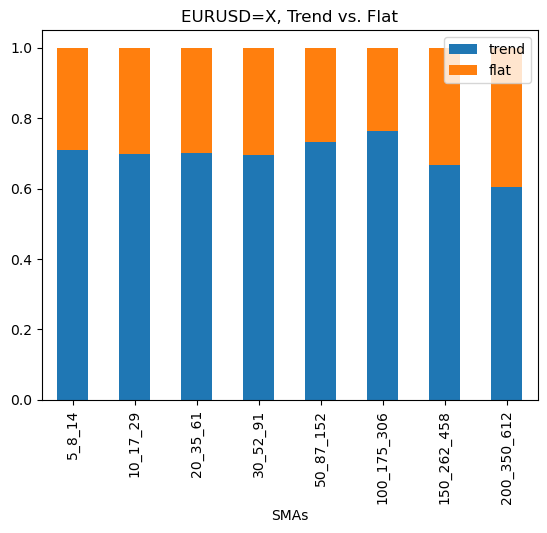

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: GBPUSD=X
DATES: 2006-04-06 - 2022-09-22
TREND, AVERAGE: 68.12%


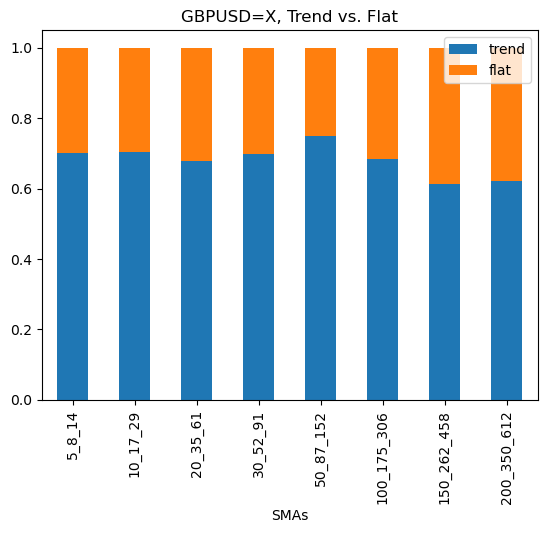

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: AUDUSD=X
DATES: 2008-09-25 - 2022-09-22
TREND, AVERAGE: 71.12%


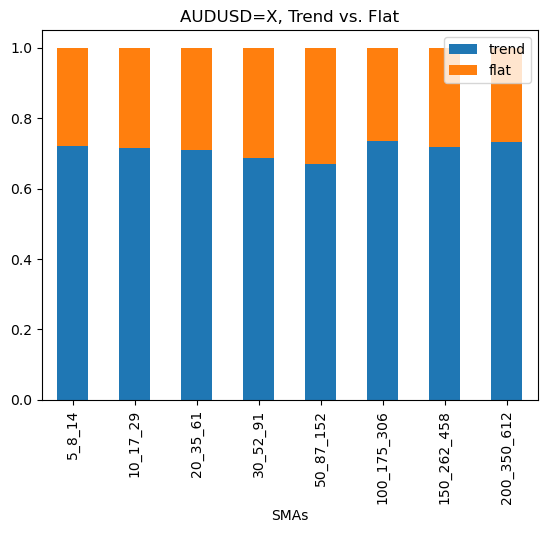

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: NZDUSD=X
DATES: 2006-04-27 - 2022-09-22
TREND, AVERAGE: 69.84%


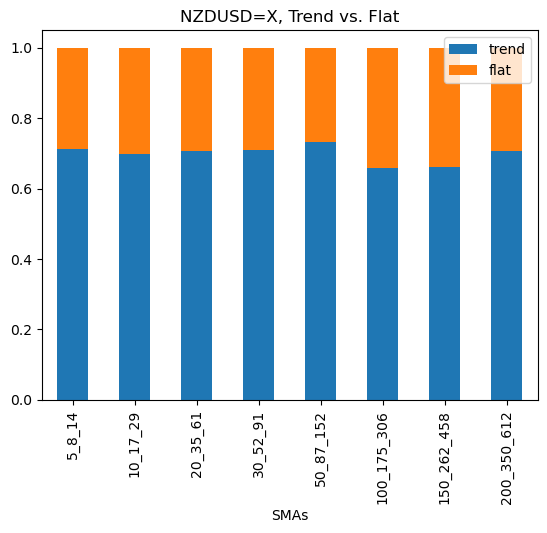

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: CAD=X
DATES: 2006-01-23 - 2022-09-22
TREND, AVERAGE: 69.84%


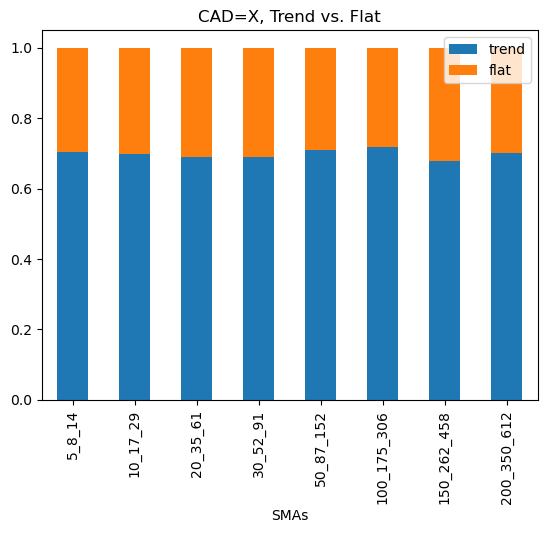

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: JPY=X
DATES: 2002-05-06 - 2022-09-22
TREND, AVERAGE: 71.83%


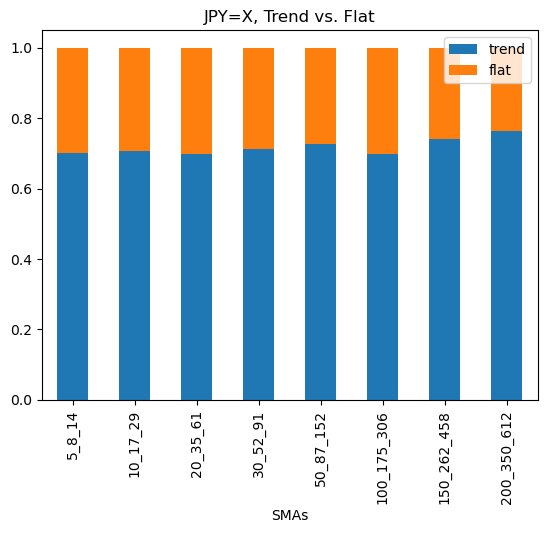

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: EURJPY=X
DATES: 2005-05-30 - 2022-09-22
TREND, AVERAGE: 71.35%


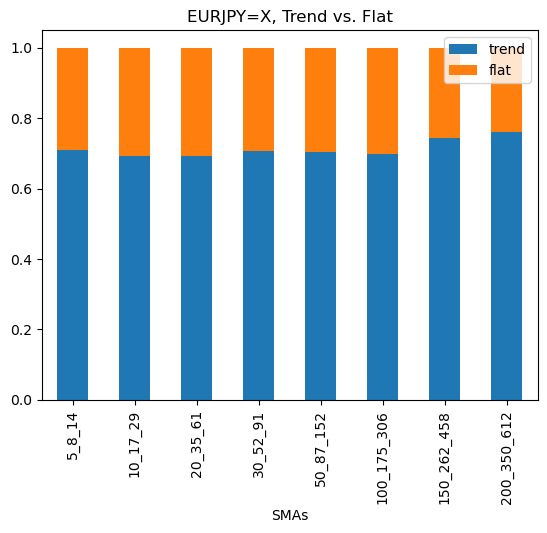

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: GBPJPY=X
DATES: 2006-04-06 - 2022-09-22
TREND, AVERAGE: 73.19%


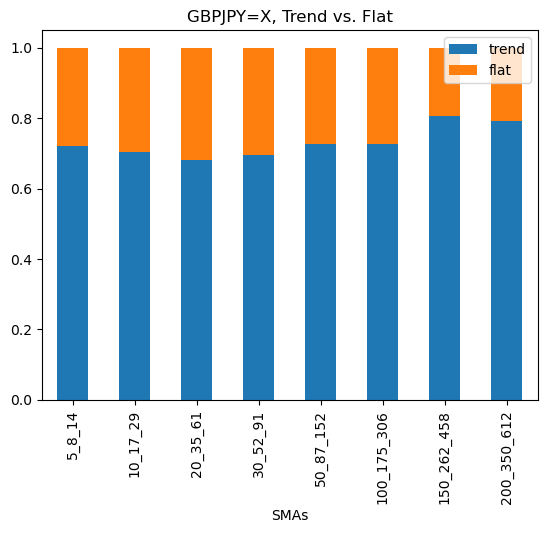

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TICKER: EURGBP=X
DATES: 2002-05-06 - 2022-09-22
TREND, AVERAGE: 67.33%


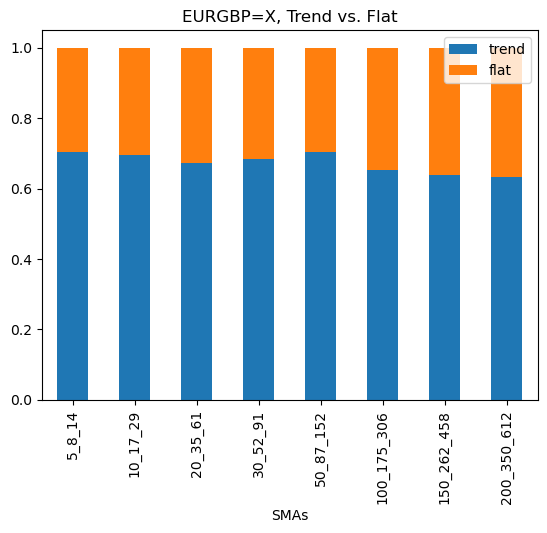

In [16]:
tickers = ["EURUSD=X", "GBPUSD=X", "AUDUSD=X", "NZDUSD=X", "CAD=X", "JPY=X", 
           "EURJPY=X", "GBPJPY=X", "EURGBP=X"]

date_from = '2000-01-01'
date_to = '2022-09-23'
sma_mult = 1.75

smas = [5, 10, 20, 30, 50, 100, 150, 200]

for ticker in tickers:
    result = {"SMAs": [], "trend": [], "flat": []}
    
    for i in smas:
        tr_fl = trend_flat(ticker, date_from, date_to, i, sma_mult)
        result["SMAs"].append(tr_fl[0])
        result["trend"].append(tr_fl[1])
        result["flat"].append(tr_fl[2])
        
    print(f'\n\nTICKER: {ticker}')
    print(f'DATES: {tr_fl[3]} - {tr_fl[4]}')
    print(f'TREND, AVERAGE: {round(sum(result["trend"]) / len(result["trend"]) * 100, 2)}%')

    r_df = pd.DataFrame(result)
    r_df.plot.bar(x='SMAs', stacked=True)
    plt.title(f"{ticker}, Trend vs. Flat")
    plt.show()